# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from prettytable import PrettyTable

In [3]:
# sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from scipy.stats import mode
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Initialisation

In [5]:
naive_sub= pd.read_parquet('taxi/naive_submission.parquet')
df= pd.read_parquet('taxi/train.parquet')
test= pd.read_parquet('taxi/test.parquet')

# Préparation des données

In [7]:
columns = list(df.columns)
# Variable qualitative ou quantitative
quantitative_vars = ['passenger_count','trip_distance', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon', 'fare_amount', 'tolls_amount', 'extra']
qualitative_vars = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']
variable_cible = 'tip_amount'


# Supprime observation nombre de passagers = 8 de nos données
# Nous définissons un nouveau dataframe sur lequel nous faisons des transformations
df_filtered = df.copy()
index_8 = df_filtered[df_filtered['passenger_count']==7].index
df_filtered = df_filtered.drop(index_8, axis=0)

# Convertir en numérique les colonnes qui devraient l'être
for col in quantitative_vars:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

for col in qualitative_vars:
    df_filtered[col] = df_filtered[col].astype('category')

# Variable binaire
for col in ['store_and_fwd_flag','VendorID', 'mta_tax', 'congestion_surcharge', 'Airport_fee']:
    df_filtered[col] = pd.factorize(df_filtered[col])[0] + 1

# Variable improvement surcharge
df_filtered['improvement_surcharge'] = pd.factorize(df_filtered['improvement_surcharge'])[0] + 1

# RatecodeID en entiers
df_filtered['RatecodeID'] = df_filtered['RatecodeID'].astype(int)

# Convertir les autres colonnes en type "category" pour les colonnes catégorielles
for col in qualitative_vars:
    df_filtered[col] = df_filtered[col].astype('category')

# Convertion en format data heure
df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
df_filtered['tpep_dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])

df_filtered = df_filtered.reset_index(drop=True)

# Feature engineering

In [9]:
df_fe = pd.DataFrame()

### Variables temporelles

In [10]:
# Calculer le temps de trajet + nouvelle variable trajet moyen
df_fe['trip_duration'] = (df_filtered['tpep_dropoff_datetime'] - df_filtered['tpep_pickup_datetime']).dt.total_seconds() / 60

df_fe['average_speed'] = df_filtered['trip_distance']/df_fe['trip_duration']
df_fe = df_fe.drop(['trip_duration'], axis=1)

In [11]:
# Creer une variable "time_of_day": (matin, midi, soir)
# Nous choisissons de definir matin : 5h-12h, midi : 12h-18h, soir : 18h-5h
def time_of_day(hour):
    if 4 <= hour < 12:
        return 0
    elif 12 <= hour < 18:
        return 1
    else:
        return 2

df_fe['time_of_day'] = df_filtered['tpep_pickup_datetime'].dt.hour.apply(time_of_day)

In [12]:
# Creer une variable binaire indiquant si le trajet a eu lieu pendant le weekend (vendredi compris)
df_fe['is_weekend'] = df_filtered['tpep_pickup_datetime'].dt.dayofweek.apply(lambda x: True if x >= 5 else False)

### Petite analyse de la méthode de paiement

In [13]:
# Pourboire moyen par méthode de paiement
print('Carte de crédit:',np.mean(df_filtered[df_filtered['payment_type']==1]['tip_amount']))
print('Espèce:', np.mean(df_filtered[df_filtered['payment_type']==2]['tip_amount']))
print('Aucune charge:',np.mean(df_filtered[df_filtered['payment_type']==3]['tip_amount']))
print('Litige:',np.mean(df_filtered[df_filtered['payment_type']==4]['tip_amount']))

Carte de crédit: 4.113448354415203
Espèce: 0.0
Aucune charge: 0.0
Litige: 0.001176470588235294


In [14]:
# Il y a une observation avec un pourboire non nul pour une méthode paiement différente de carte de crédit. Potentiel outlier
print(df_filtered.loc[(df_filtered['payment_type'] == 4) & (df_filtered['tip_amount'] == 1)].shape[0])

1


In [15]:
print(f"observations où le paiement a été effectué par carte de crédit {len(df_filtered[df_filtered['payment_type']==1])}")

observations où le paiement a été effectué par carte de crédit 83405


### Données coordonnées

In [16]:
# Clusterisation des quartiers/zones pour point de départ et arrivée
# Appliquer KMeans pour 10 clusters
kmeans_pickup = KMeans(n_clusters=10, random_state=42)
df_fe['pickup_cluster'] = kmeans_pickup.fit_predict(df_filtered[['PU_location_lat', 'PU_location_lon']])

kmeans_dropoff = KMeans(n_clusters=10, random_state=42)
df_fe['dropoff_cluster'] = kmeans_dropoff.fit_predict(df_filtered[['DO_location_lat', 'DO_location_lon']])

### Frais supplémentaires

In [17]:
# Somme des variables "frais""+ suppression"

df_fe[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']] = df_filtered[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']].apply(pd.to_numeric, errors='coerce')
df_fe['total_extra_fees'] = df_fe[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']].sum(axis=1)
df_fe = df_fe.drop(['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee'], axis=1)

### Fonction de transformation des données

In [18]:
# Transformation du nouveau dataframe
def transform_df_fe(df, km_pickup, km_dropoff):
    # Supprime cette observation de nos données
    # Nous définissons un nouveau dataframe sur lequel nous faisons des transformations
    df_filtered = df.copy()

    # Convertir en numérique les colonnes qui devraient l'être
    for col in quantitative_vars:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

    # Variable catégorielles
    for col in ['store_and_fwd_flag','VendorID', 'mta_tax', 'congestion_surcharge', 'Airport_fee', 'improvement_surcharge']:
        to_map = np.unique(df_filtered[col])
        df_filtered[col] = df_filtered[col].map({to_map[0]: 0, to_map[1]: 1})

    # RatecodeID en entiers
    df_filtered['RatecodeID'] = df_filtered['RatecodeID'].astype(int)

    # Convertir les autres colonnes en type "category" pour les colonnes catégorielles
    for col in qualitative_vars:
        df_filtered[col] = df_filtered[col].astype('category')

    # Feauter engineering
    # Convertion en format data heure
    df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
    df_filtered['tpep_dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])

    df_fe = pd.DataFrame()
    # Calculer le temps de trajet + nouvelle variable trajet moyen
    df_fe['trip_duration'] = (df_filtered['tpep_dropoff_datetime'] - df_filtered['tpep_pickup_datetime']).dt.total_seconds() / 60

    # df_fe['average_speed'] = df_filtered['trip_distance']/df_fe['trip_duration']
    df_fe['average_speed'] = np.where(df_fe['trip_duration'] == 0, 0, df_filtered['trip_distance'] / df_fe['trip_duration'])
    
    df_fe = df_fe.drop(['trip_duration'], axis=1)

    # Time of day
    df_fe['time_of_day'] = df_filtered['tpep_pickup_datetime'].dt.hour.apply(time_of_day)

    # Creer une variable binaire indiquant si le trajet a eu lieu pendant le weekend (vendredi compris)
    df_fe['is_weekend'] = df_filtered['tpep_pickup_datetime'].dt.dayofweek.apply(lambda x: True if x >= 5 else False)

    df_fe['pickup_cluster'] = km_pickup.predict(df_filtered[['PU_location_lat', 'PU_location_lon']])
    df_fe['dropoff_cluster'] = km_dropoff.predict(df_filtered[['DO_location_lat', 'DO_location_lon']])

    # Frais supplementaire
    df_fe[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']] = df_filtered[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']].apply(pd.to_numeric, errors='coerce')
    df_fe['total_extra_fees'] = df_fe[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']].sum(axis=1)
    df_fe = df_fe.drop(['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee'], axis=1)

    # to category
    for col in ['time_of_day', 'pickup_cluster', 'dropoff_cluster']:
        df_fe[col] = df_fe[col].astype('category')

    # Enlever les variables inutiles
    to_remove = ['PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge','store_and_fwd_flag']
    df_filtered = df_filtered.drop(to_remove, axis=1)

    df_filtered = df_filtered.join(df_fe)

    return df_filtered

# Test des performances des modèles sur données après feature engineering

Les modèles seront entraînés uniquement sur les données pour laquelle le omde de paiement est la carte de crédit

In [25]:
X = df_filtered.drop(['tip_amount', 'tpep_pickup_datetime', 'tpep_dropoff_datetime'],axis=1)
y = df_filtered['tip_amount']

### Données avec methode de paiement: carte de credit (==1)
df_filtered2 = df_filtered[df_filtered['payment_type']==1]

X22 = df_filtered2.drop(['tip_amount'],axis=1)
X22  = transform_df_fe(X22, kmeans_pickup, kmeans_dropoff)
X22 = X22.drop('payment_type', axis=1)

y22 = df_filtered2['tip_amount']

In [26]:
X_tr, X_te, y_tr, y_te = train_test_split(X22, y22, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

features = X_train.columns

In [27]:
categories_for_xgb = ['VendorID', 
                      'RatecodeID', 
                      'store_and_fwd_flag', 
                      'payment_type', 
                      'mta_tax', 
                      'improvement_surcharge', 
                      'congestion_surcharge', 
                      'Airport_fee']

# Transformation des données pour répondre aux demandes de XGBoost
# One hot encode les variables catégorielles
def xgboost_data(df, categories):
    df_encoded = pd.get_dummies(df, columns = categories)
    return df_encoded

In [29]:
# Sur données originales

models = {
    "XGBoost": XGBRegressor(enable_categorical=True),
    "CatBoost": CatBoostRegressor(random_seed=42, verbose=0, cat_features=categories_for_xgb),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),    
    "LightGBM": LGBMRegressor(random_state=42, verbose=0),
    "Extra Trees Regressor": ExtraTreesRegressor(random_state=42)
}

mse_scores_default = {}
mae_scores_default = {}
r2_scores_default = {}
max_error_scores_default = {}

for method, model in models.items():
    print(method)
    if method == 'SVR':
        index = np.random.randint(0, len(X_train), 5000)
        X_train_subset = X_train.iloc[index]
        y_train_subset = y_train.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    elif method == 'XGBoost':
        X_train_xgb = xgboost_data(X_train, categories_for_xgb)
        base_model = model.fit(X_train_xgb, y_train)
    else:
        base_model = model.fit(X_train, y_train)

    if method == 'XGBoost':
        X_test_xgb = xgboost_data(X_test, categories_for_xgb)
        y_pred = base_model.predict(X_test_xgb)
    else: 
        y_pred = base_model.predict(X_test)
    
    # Calculate metrics correctly with y_test first
    mse_scores_default[method] = mean_squared_error(y_test, y_pred)
    mae_scores_default[method] = mean_absolute_error(y_test, y_pred)
    r2_scores_default[method] = r2_score(y_test, y_pred)
    max_error_scores_default[method] = max_error(y_test, y_pred)

XGBoost
CatBoost
Random Forest Regressor
SVR
Gradient Boosting
LightGBM
Extra Trees Regressor


In [30]:
models = {
    "XGBoost": XGBRegressor(enable_categorical=True),
    "CatBoost": CatBoostRegressor(random_seed=42, verbose=0, cat_features=['time_of_day', 'pickup_cluster', 'dropoff_cluster', 'VendorID', 'RatecodeID','Airport_fee']),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),    
    "LightGBM": LGBMRegressor(random_state=42, verbose=0),
    "Extra Trees Regressor": ExtraTreesRegressor(random_state=42)
}

mse_scores_fe = {}
mae_scores_fe = {}
r2_scores_fe = {}
max_error_scores_fe = {}

for method, model in models.items():
    print(method)
    if method == 'SVR':
        index = np.random.randint(0, len(X_tr), 5000)
        X_train_subset = X_tr.iloc[index]
        y_train_subset = y_tr.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    else:
        base_model = model.fit(X_tr, y_tr)

    y_pred = base_model.predict(X_te)
    
    # Calculate metrics correctly with y_test first
    mse_scores_fe[method] = mean_squared_error(y_te, y_pred)
    mae_scores_fe[method] = mean_absolute_error(y_te, y_pred)
    r2_scores_fe[method] = r2_score(y_te, y_pred)
    max_error_scores_fe[method] = max_error(y_te, y_pred)

XGBoost
CatBoost
Random Forest Regressor
SVR
Gradient Boosting
LightGBM
Extra Trees Regressor


In [31]:
mse_scores_comp = []
for method in list(mse_scores_fe.keys()):
    mse_scores_comp.append([mse_scores_default[method], mse_scores_fe[method]])
mse_scores_comp = np.array([np.round(list(i),3) for i in mse_scores_comp])

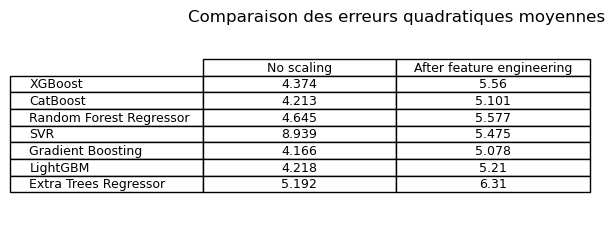

In [32]:
# Plot
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.axis('off')

the_table = ax.table(cellText=mse_scores_comp, colLabels=['No scaling', 'After feature engineering'], rowLabels=list(mse_scores_fe.keys()), loc='center',cellLoc='center')
plt.title('Comparaison des erreurs quadratiques moyennes')

plt.show()

Text(0.5, 0, 'Importance')

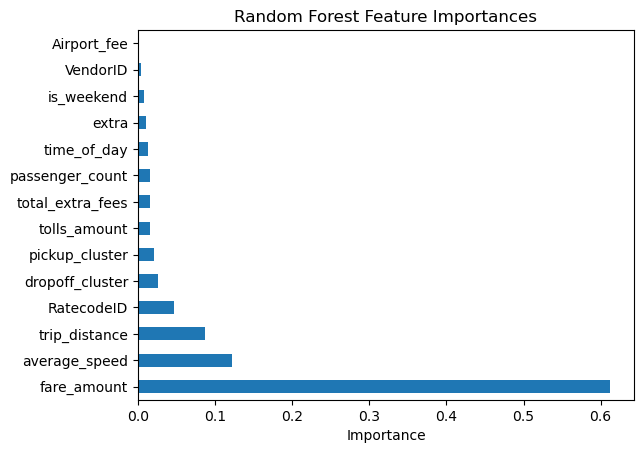

In [33]:
# Importance des variables lors de l'entrainement sur les donnees feature engineered (uniquement carte bancaire)
rfc_model = RandomForestRegressor()
rfc_model.fit(X22, y22)
imp = rfc_model.feature_importances_
forest_imp = pd.Series(imp, index = X22.columns)
forest_imp = forest_imp.sort_values(ascending=False)

# Plot les importances
fig = plt.figure()

forest_imp.plot.barh()
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')